# ***Baseline Using Pre-trained backbone + Neck + head***</center>


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
import cv2
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import zipfile

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch Version: 2.9.0+cu126
CUDA Available: True
CUDA Device: Tesla T4
Using device: cuda


## 1) Download + Extract GTSDB from Kaggle

In [ ]:
import os
import zipfile
from google.colab import files

# Kaggle setup
!mkdir -p ~/.kaggle

print("Upload kaggle.json:")
uploaded = files.upload()

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
print("Downloading GTSDB dataset...")
!kaggle datasets download -d safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb

# Extract dataset
print("Extracting...")
with zipfile.ZipFile('german-traffic-sign-detection-benchmark-gtsdb.zip', 'r') as f:
    f.extractall('gtsdb_data')

print("Dataset ready!")


Upload kaggle.json:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb
License(s): unknown
 97% 1.56G/1.61G [00:19<00:00, 127MB/s] 
100% 1.61G/1.61G [00:19<00:00, 88.3MB/s]
Extracting...
Dataset ready!


## 2) Define Dataset Paths

In [ ]:
DATASET_ROOT = "gtsdb_data"

TRAIN_DIR = os.path.join(DATASET_ROOT, "TrainIJCNN2013", "TrainIJCNN2013")
TEST_DIR  = os.path.join(DATASET_ROOT, "TestIJCNN2013", "TestIJCNN2013Download")

print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR:", TEST_DIR)


TRAIN_DIR: gtsdb_data/TrainIJCNN2013/TrainIJCNN2013
TEST_DIR: gtsdb_data/TestIJCNN2013/TestIJCNN2013Download


## 3) Inspect Directories

In [ ]:
print("\nChecking dataset structure...\n")

if os.path.exists(TRAIN_DIR):
    train_files = sorted([f for f in os.listdir(TRAIN_DIR) if f.endswith(".ppm")])
    print(f"Train images: {len(train_files)}")
    print("First 5 train images:", train_files[:5])
else:
    print(" TRAIN directory not found!")

if os.path.exists(TEST_DIR):
    test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith(".ppm")])
    print(f"Test images: {len(test_files)}")
    print("First 5 test images:", test_files[:5])
else:
    print(" TEST directory not found!")



Checking dataset structure...

Train images: 600
First 5 train images: ['00000.ppm', '00001.ppm', '00002.ppm', '00003.ppm', '00004.ppm']
Test images: 300
First 5 test images: ['00000.ppm', '00001.ppm', '00002.ppm', '00003.ppm', '00004.ppm']


## 4) Dataset Class (CLEAN)

In [ ]:
class GTSDBDataset(Dataset):
    def __init__(self, root_dir, transforms=None, indices=None):
        """
        root_dir : folder containing images and gt.txt
        transforms: albumentations.Compose or None
        indices  : list/array of indices to keep (optional)
        """
        self.root_dir = root_dir
        self.transforms = transforms


        annotations = {}
        gt_file = os.path.join(root_dir, "gt.txt")
        if not os.path.exists(gt_file):
            raise FileNotFoundError("gt.txt not found in: " + root_dir)

        with open(gt_file, "r") as f:
            for line in f:
                parts = line.strip().split(";")
                img_name = parts[0]
                x1, y1, x2, y2 = map(int, parts[1:5])
                cls = int(parts[5]) + 1

                if img_name not in annotations:
                    annotations[img_name] = {"boxes": [], "labels": []}

                annotations[img_name]["boxes"].append([x1, y1, x2, y2])
                annotations[img_name]["labels"].append(cls)


        self.images = []
        self.targets = []
        for img_name, ann in sorted(annotations.items()):
            img_path = os.path.join(root_dir, img_name)
            if not os.path.exists(img_path):
                continue

            self.images.append(img_path)
            boxes = torch.tensor(ann["boxes"], dtype=torch.float32)
            labels = torch.tensor(ann["labels"], dtype=torch.int64)
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
            self.targets.append({
                "boxes": boxes,
                "labels": labels,
                "area": area,
                "iscrowd": iscrowd,
            })


        if indices is not None:
            self.images = [self.images[i] for i in indices]
            self.targets = [self.targets[i] for i in indices]

        print(f" Loaded {len(self.images)} images with bounding boxes. (transforms={'yes' if transforms else 'no'})")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        target = self.targets[idx].copy()

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        boxes = target["boxes"].numpy().astype(float).tolist()
        labels = target["labels"].numpy().tolist()

        if self.transforms:
            augmented = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = augmented['image']
            boxes = augmented['bboxes']
            labels = augmented['labels']
        else:
            img = img

        img = torch.from_numpy(img).permute(2,0,1).float() / 255.0

        boxes_t = torch.tensor(boxes, dtype=torch.float32) if len(boxes) > 0 else torch.zeros((0,4), dtype=torch.float32)
        labels_t = torch.tensor(labels, dtype=torch.int64) if len(labels) > 0 else torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes_t,
            "labels": labels_t,
            "area": (boxes_t[:,2] - boxes_t[:,0]) * (boxes_t[:,3] - boxes_t[:,1]) if boxes_t.numel() else torch.zeros((0,)),
            "iscrowd": torch.zeros((len(labels_t),), dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        return img, target


## 5) Create Dataset + DataLoader

In [ ]:
dataset = GTSDBDataset("/content/gtsdb_data/TrainIJCNN2013/TrainIJCNN2013")
print("Total images:", len(dataset))


 Loaded 506 images with bounding boxes. (transforms=no)
Total images: 506


In [ ]:
dataset = GTSDBDataset(root_dir=TRAIN_DIR)

print(f"Total samples in dataset: {len(dataset)}")

 Loaded 506 images with bounding boxes. (transforms=no)
Total samples in dataset: 506


# 6) Data visualization

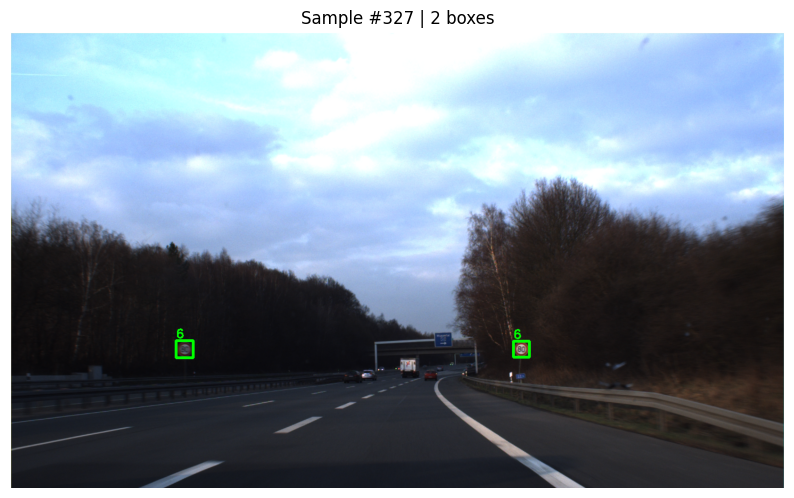

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2

def visualize_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)

    img, target = dataset[idx]

    img_np = img.permute(1, 2, 0).numpy().copy()
    img_np = (img_np * 255).astype("uint8")

    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()

    img_draw = img_np.copy()

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_draw, (x1, y1), (x2, y2), (0,255,0), 3)
        cv2.putText(img_draw, str(label), (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    plt.figure(figsize=(10, 7))
    plt.imshow(img_draw)
    plt.title(f"Sample #{idx} | {len(boxes)} boxes")
    plt.axis("off")
    plt.show()

# RUN IT
visualize_random_sample(dataset)


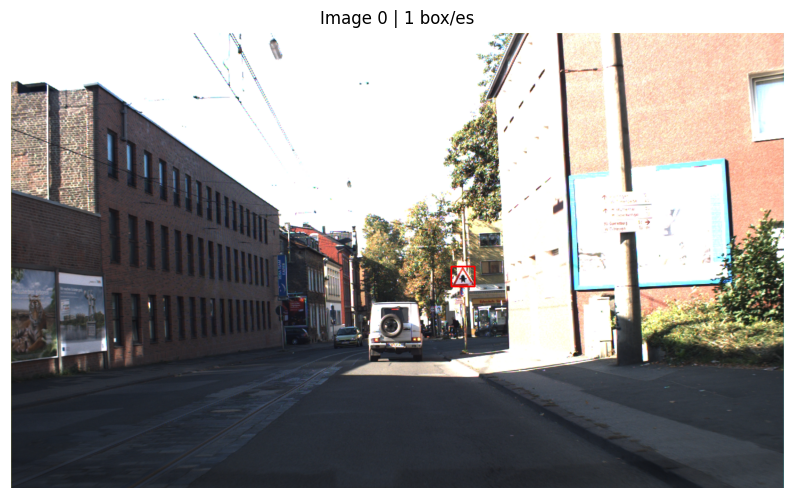

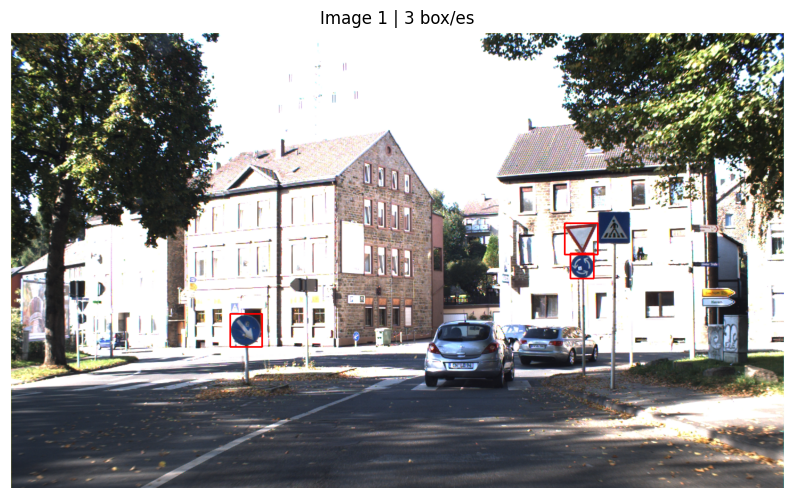

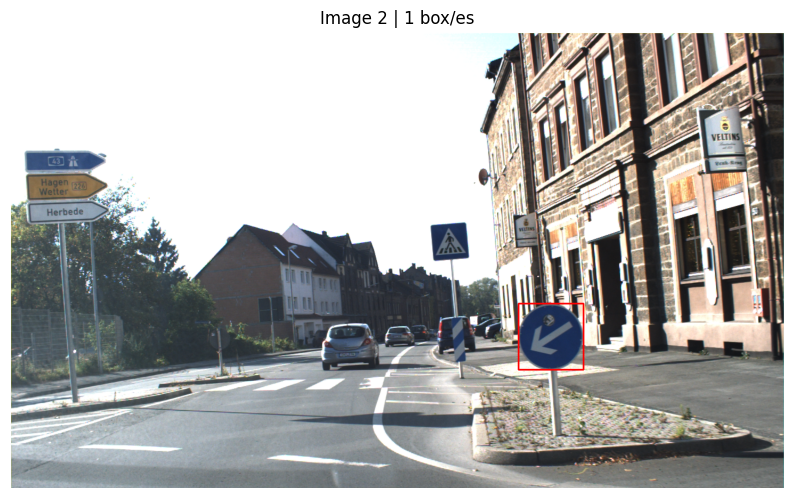

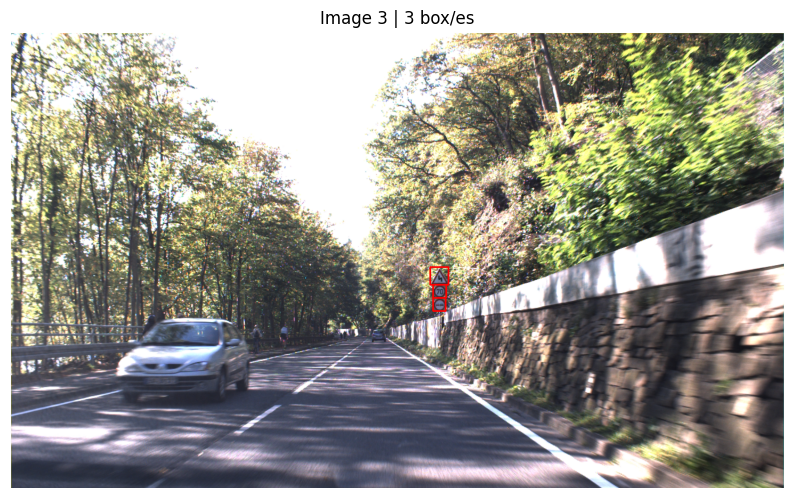

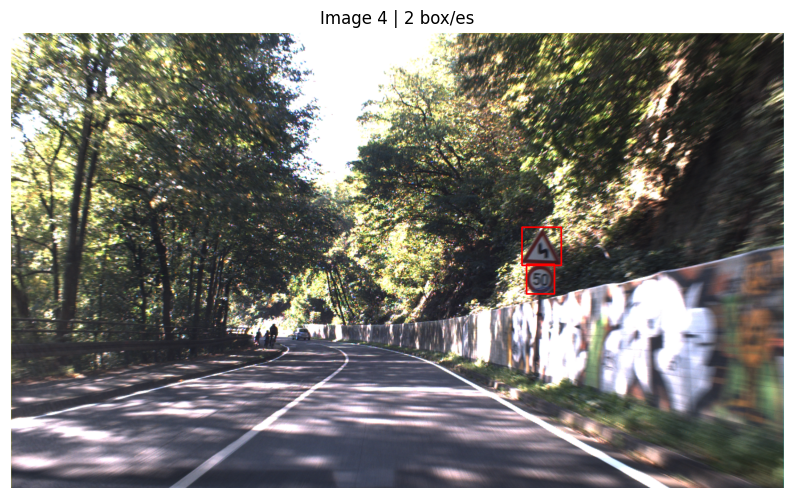

In [ ]:
def visualize_first_n(dataset, n=5):
    for i in range(n):
        img, target = dataset[i]
        img_np = img.permute(1,2,0).numpy()
        boxes = target["boxes"].numpy()

        img_draw = img_np.copy()
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_draw, (x1, y1), (x2, y2), (255,0,0), 2)

        plt.figure(figsize=(10,7))
        plt.imshow(img_draw)
        plt.title(f"Image {i} | {len(boxes)} box/es")
        plt.axis("off")
        plt.show()

visualize_first_n(dataset, n=5)


# 7) Data Augmentation

In [ ]:
!pip install -q albumentations==1.3.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 11.2 MB/s eta 0:00:00


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch
import cv2


train_aug = A.Compose([
    A.Rotate(limit=8, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))



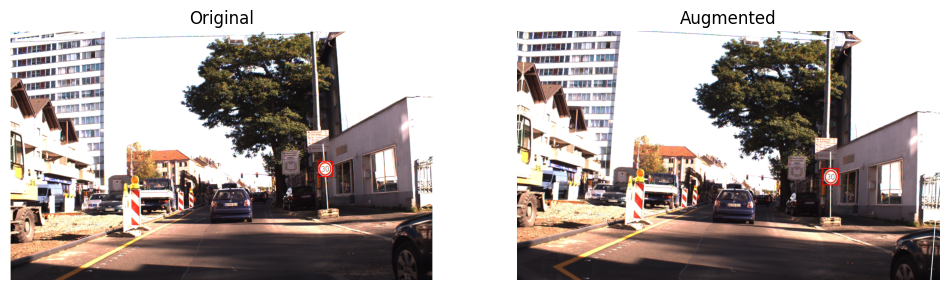

In [ ]:
import matplotlib.pyplot as plt
import random
import cv2

def draw_boxes_on_np(img_np, boxes, labels, color=(255,0,0)):
    out = img_np.copy()
    for (x1,y1,x2,y2), lbl in zip(boxes, labels):
        cv2.rectangle(out, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        cv2.putText(out, str(int(lbl)), (int(x1), int(max(0,y1-5))), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return out

# show one example before/after
idx = random.randint(0, len(dataset)-1)
img_path = dataset.images[idx]
orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
boxes = dataset.targets[idx]['boxes'].numpy()
labels = dataset.targets[idx]['labels'].numpy()

# apply albumentations transform directly for visualization
aug = train_aug(image=orig, bboxes=boxes.tolist(), labels=labels.tolist())
img_aug = aug['image']; boxes_aug = aug['bboxes']; labels_aug = aug['labels']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(draw_boxes_on_np(orig, boxes, labels))
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Augmented')
plt.imshow(draw_boxes_on_np(img_aug, boxes_aug, labels_aug))
plt.axis('off')

plt.show()


# 8) Create a reproducible train/val split and datasets with different transforms

In [ ]:
# Prepare a full dataset object (no transforms) just to get length / index mapping
full_dataset = GTSDBDataset(root_dir=TRAIN_DIR, transforms=None)

num_samples = len(full_dataset)
all_indices = list(range(num_samples))

# reproducible split
from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(all_indices, test_size=0.2, random_state=seed, shuffle=True)

print(f"Total samples: {num_samples} | Train: {len(train_idx)} | Val: {len(val_idx)}")

# Create dataset objects that point to same underlying annotations but different transforms
train_dataset = GTSDBDataset(root_dir=TRAIN_DIR, transforms=train_aug, indices=train_idx)
val_dataset   = GTSDBDataset(root_dir=TRAIN_DIR, transforms=None,      indices=val_idx)


def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False, collate_fn=collate_fn)


 Loaded 506 images with bounding boxes. (transforms=no)
Total samples: 506 | Train: 404 | Val: 102
 Loaded 404 images with bounding boxes. (transforms=yes)
 Loaded 102 images with bounding boxes. (transforms=no)


## 9) Quick visual check to confirm augmentation is applied only to train_dataset

Random train sample:
Random val sample:


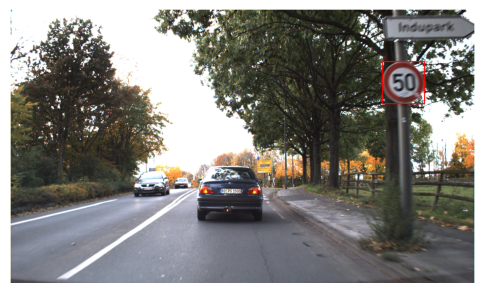

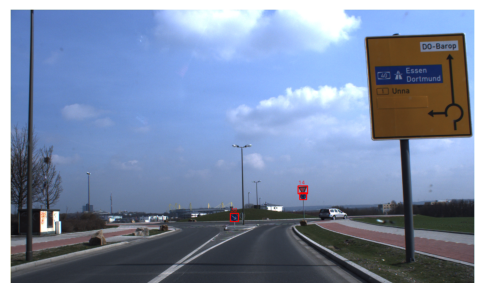

In [ ]:

def show_sample_from_dataset(ds, idx):
    img, target = ds[idx]
    img_np = img.permute(1,2,0).numpy()
    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()
    plt.figure(figsize=(6,4))
    plt.imshow(draw_boxes_on_np((img_np*255).astype('uint8'), boxes, labels))
    plt.axis('off')

print("Random train sample:")
show_sample_from_dataset(train_dataset, random.randint(0, len(train_dataset)-1))

print("Random val sample:")
show_sample_from_dataset(val_dataset, random.randint(0, len(val_dataset)-1))


## 6) Build Faster R-CNN Model

In [5]:
import torch
import torch.nn as nn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def get_ground_truth_model(num_classes):
    backbone = resnet_fpn_backbone(
        backbone_name="resnet50",
        weights="IMAGENET1K_V2",
        trainable_layers=3
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        min_size=600,
        max_size=1000
    )
    return model


model = get_ground_truth_model(num_classes=44).to("cuda")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


## 7) Training Loop

In [ ]:
import torch
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import time
import os
import json


optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()
num_epochs = 25

train_losses_epoch = []
val_losses_epoch = []


save_dir = "./training_runs/2025-12-04_22-10-00"
os.makedirs(save_dir, exist_ok=True)
best_val_loss = float("inf")

print(" Starting Training...\n")


for epoch in range(num_epochs):


    model.train()
    total_train_loss = 0.0
    start = time.time()

    for batch_idx, (images, targets) in enumerate(train_loader):

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with autocast():
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses_epoch.append(avg_train_loss)
    print(f"\n Epoch {epoch+1} finished | Avg Training Loss: {avg_train_loss:.4f} | Time: {time.time() - start:.2f}s")


    model.train()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses_epoch.append(avg_val_loss)
    print(f" Validation Loss: {avg_val_loss:.4f}\n")


    epoch_path = os.path.join(save_dir, f"epoch_{epoch+1:03d}.pth")
    torch.save(model.state_dict(), epoch_path)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(save_dir, "best_model.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f" Best model updated! Saved to {best_model_path}")


history = {
    "train_losses_epoch": train_losses_epoch,
    "val_losses_epoch": val_losses_epoch
}
history_path = os.path.join(save_dir, "history.json")
with open(history_path, "w") as f:
    json.dump(history, f)

print("\n Training Completed! History saved →", history_path)


 Starting Training...

Epoch 1/25 | Batch 0/101 | Loss: 4.7369
Epoch 1/25 | Batch 10/101 | Loss: 0.7327
Epoch 1/25 | Batch 20/101 | Loss: 0.2057
Epoch 1/25 | Batch 30/101 | Loss: 0.4444
Epoch 1/25 | Batch 40/101 | Loss: 0.1866
Epoch 1/25 | Batch 50/101 | Loss: 0.2331
Epoch 1/25 | Batch 60/101 | Loss: 0.2439
Epoch 1/25 | Batch 70/101 | Loss: 0.5070
Epoch 1/25 | Batch 80/101 | Loss: 0.2718
Epoch 1/25 | Batch 90/101 | Loss: 0.3863
Epoch 1/25 | Batch 100/101 | Loss: 0.4302

 Epoch 1 finished | Avg Training Loss: 0.4845 | Time: 50.75s
 Validation Loss: 0.3354

 Best model updated! Saved to ./training_runs/2025-12-04_22-10-00/best_model.pth
Epoch 2/25 | Batch 0/101 | Loss: 0.3855
Epoch 2/25 | Batch 10/101 | Loss: 0.2111
Epoch 2/25 | Batch 20/101 | Loss: 0.3286
Epoch 2/25 | Batch 30/101 | Loss: 0.3065
Epoch 2/25 | Batch 40/101 | Loss: 0.3385
Epoch 2/25 | Batch 50/101 | Loss: 0.1749
Epoch 2/25 | Batch 60/101 | Loss: 0.4704
Epoch 2/25 | Batch 70/101 | Loss: 0.2807
Epoch 2/25 | Batch 80/101 | Lo

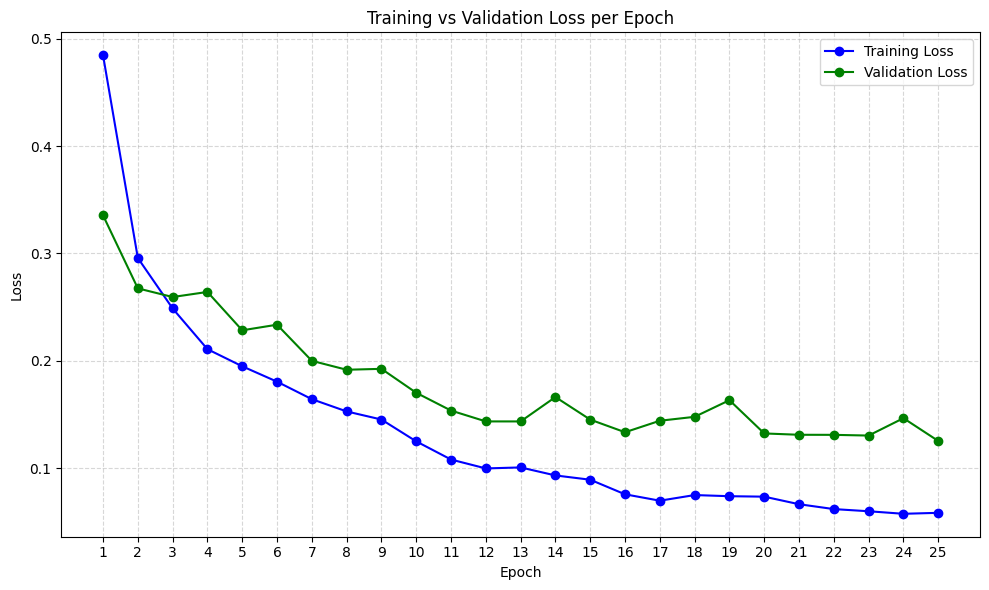

 Loss curve saved to: /content/training_runs/2025-12-04_22-10-00/loss_curve.png


In [ ]:
import json
import matplotlib.pyplot as plt
import os


save_dir = "/content/training_runs/2025-12-04_22-10-00"
history_path = os.path.join(save_dir, "history.json")

with open(history_path, "r") as f:
    history = json.load(f)

train_losses = history["train_losses_epoch"]
val_losses = history["val_losses_epoch"]
epochs = range(1, len(train_losses) + 1)


plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, "o-", color="blue", label="Training Loss")
plt.plot(epochs, val_losses, "o-", color="green", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss per Epoch")
plt.xticks(epochs)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()


plot_path = os.path.join(save_dir, "loss_curve.png")
plt.savefig(plot_path, dpi=150)
plt.show()

print(f" Loss curve saved to: {plot_path}")


In [14]:
device = "cuda"

num_classes = 44
best_model_path = "/content/drive/MyDrive/GTSDB/best_model.pth"

model = get_ground_truth_model(num_classes)
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

print(" Loaded best_model.pth successfully!")


 Loaded best_model.pth successfully!


In [22]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision.ops import box_iou

test_folder = "/content/drive/MyDrive/GTSDB/labled_test"
anno_path = "/content/drive/MyDrive/GTSDB/anno.txt"



test_annotations = {}
with open(anno_path, "r") as f:
    for line in f:
        img, x1, y1, x2, y2, cls = line.strip().split(";")
        box = [float(x1), float(y1), float(x2), float(y2)]
        cls = int(cls)

        if img not in test_annotations:
            test_annotations[img] = {"boxes": [], "labels": []}

        test_annotations[img]["boxes"].append(box)
        test_annotations[img]["labels"].append(cls)






def evaluate_on_test(model, test_annotations, score_thresh=0.5, iou_thresh=0.5):
    precisions, recalls, f1s, aps = [], [], [], []

    for img_name, ann in test_annotations.items():
        img_path = os.path.join(test_folder, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_tensor = torch.tensor(img_rgb).permute(2,0,1).float() / 255.
        img_tensor = img_tensor.unsqueeze(0).to(device)

        gt_boxes = torch.tensor(ann["boxes"]).to(device)
        gt_labels = torch.tensor(ann["labels"]).to(device)

        with torch.no_grad():
            out = model(img_tensor)[0]

        mask = out["scores"] > score_thresh
        pred_boxes = out["boxes"][mask]
        pred_labels = out["labels"][mask]

        if len(pred_boxes) == 0:
            precisions.append(0); recalls.append(0); f1s.append(0); aps.append(0)
            continue

        ious = box_iou(pred_boxes, gt_boxes)
        matches = (ious > iou_thresh).sum(dim=1)

        TP = (matches > 0).sum().item()
        FP = len(pred_boxes) - TP
        FN = len(gt_boxes) - TP

        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        aps.append(precision)

    return {
        "Precision": sum(precisions)/len(precisions),
        "Recall": sum(recalls)/len(recalls),
        "F1-score": sum(f1s)/len(f1s),
        "mAP": sum(aps)/len(aps),
    }

metrics = evaluate_on_test(model, test_annotations)
print("Evaluation Metrics on Validation Set:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")







Evaluation Metrics on Validation Set:
Precision: 0.8900
Recall: 0.8900
F1-score: 0.8467
mAP: 0.8900


IMAGE 1: 00001.ppm
ORIGINAL SHAPE: (800, 1360, 3)
GT LABELS: [33, 7]
GT BOXES: [[665.0, 572.0, 674.0, 583.0], [83.0, 447.0, 145.0, 513.0]]

PREDICTED LABELS: [7]
PREDICTED BOXES: [[82.78994750976562, 450.7028503417969, 141.36819458007812, 508.7575988769531]]
PREDICTED SCORES: [0.9739062190055847]
IMAGE 2: 00002.ppm
ORIGINAL SHAPE: (800, 1360, 3)
GT LABELS: [8]
GT BOXES: [[443.0, 543.0, 474.0, 574.0]]

PREDICTED LABELS: [8, 7]
PREDICTED BOXES: [[1268.3035888671875, 552.7071533203125, 1298.699462890625, 586.5103759765625], [441.9889221191406, 541.6575317382812, 473.212646484375, 574.999755859375]]
PREDICTED SCORES: [0.8707304000854492, 0.679985523223877]
IMAGE 3: 00003.ppm
ORIGINAL SHAPE: (800, 1360, 3)
GT LABELS: [10]
GT BOXES: [[361.0, 442.0, 417.0, 499.0]]

PREDICTED LABELS: [10]
PREDICTED BOXES: [[359.9020080566406, 445.1851806640625, 416.74591064453125, 497.34210205078125]]
PREDICTED SCORES: [0.9244676828384399]
IMAGE 4: 00004.ppm
ORIGINAL SHAPE: (800, 1360, 3)
GT LABELS: [30]
GT BO

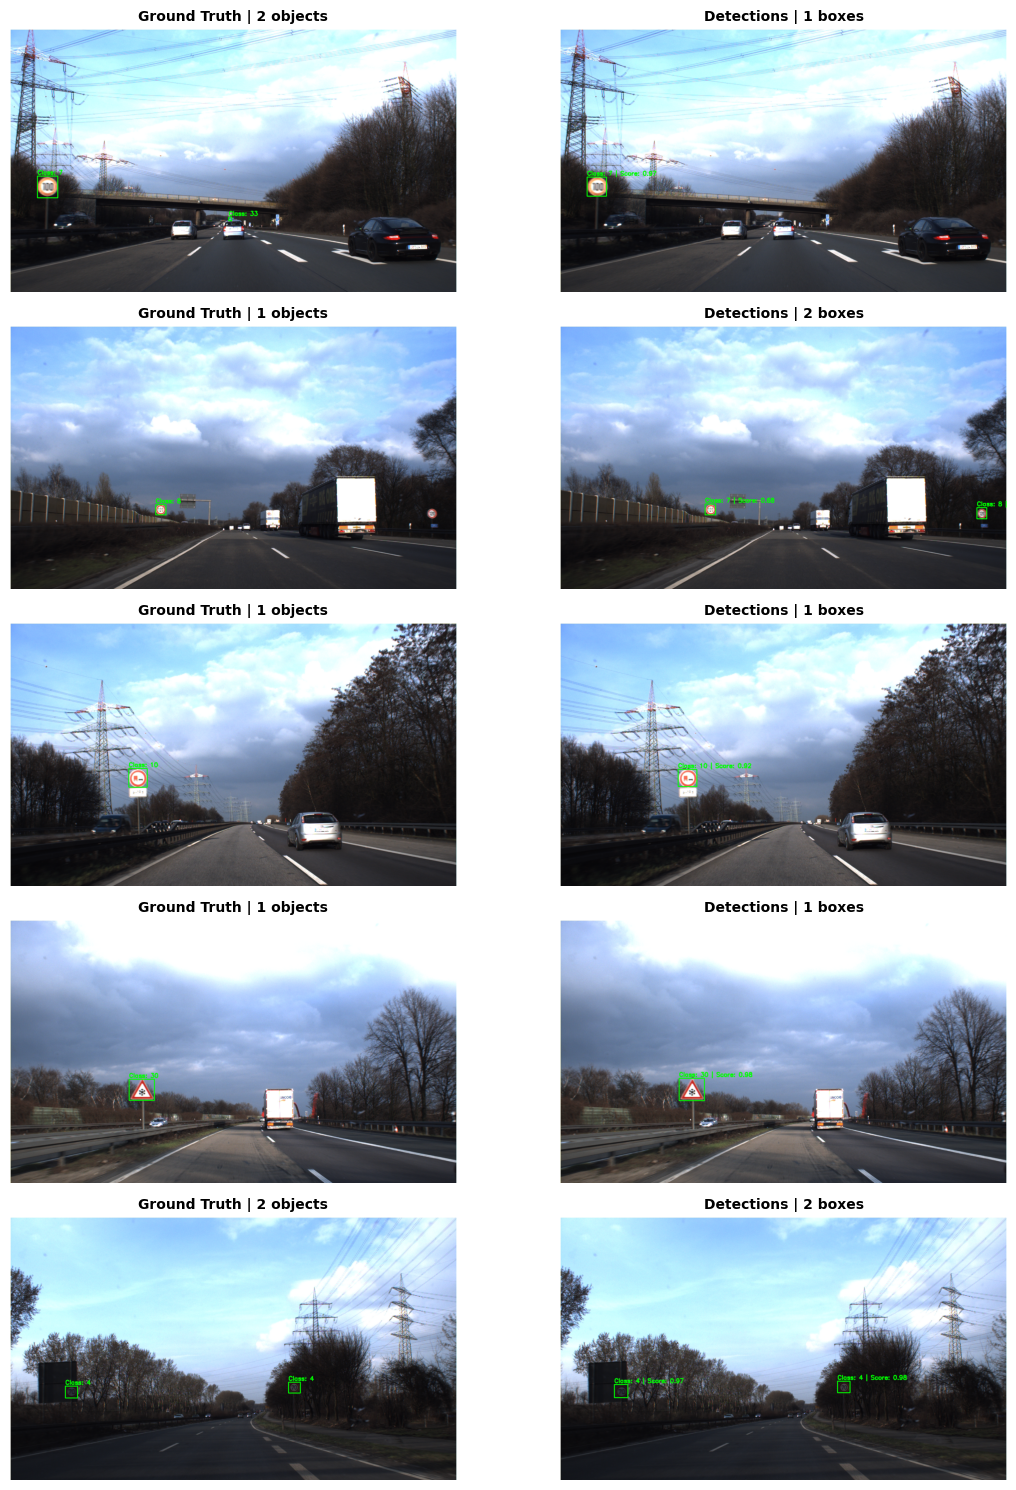

In [23]:
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np
import os


def draw_boxes(img_np, boxes, labels, scores=None, color=(0, 255, 0)):

    img = img_np.copy()

    for i, ((x1, y1, x2, y2), lbl) in enumerate(zip(boxes, labels)):
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

        if scores is not None:
            score = float(scores[i])
            text = f"Class: {int(lbl)} | Score: {score:.2f}"
        else:
            text = f"Class: {int(lbl)}"

        cv2.putText(
            img,
            text,
            (int(x1), int(max(0, y1 - 5))),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2
        )
    return img


model.eval()

max_images = 5

gt_imgs = []
pred_imgs = []
gt_counts = []
pred_counts = []

for count, (img_name, ann) in enumerate(test_annotations.items()):
    if count >= max_images:
        break


    img_path = os.path.join(test_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_np = img.copy()


    gt_boxes = np.array(ann["boxes"])
    gt_labels = np.array(ann["labels"])
    gt_img = draw_boxes(img_np, gt_boxes, gt_labels, scores=None, color=(0, 255, 0))


    print(f"IMAGE {count+1}: {img_name}")
    print("ORIGINAL SHAPE:", img_np.shape)
    print("GT LABELS:", gt_labels.tolist())
    print("GT BOXES:", gt_boxes.tolist())


    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)[0]

    mask = output["scores"] > 0.5

    pred_boxes = output["boxes"][mask].cpu().numpy()
    pred_labels = output["labels"][mask].cpu().numpy()
    pred_labels = pred_labels - 1
    pred_scores = output["scores"][mask].cpu().numpy()

    pred_img = draw_boxes(
        img_np,
        pred_boxes,
        pred_labels,
        scores=pred_scores,
        color=(0, 255, 0)
    )

    print("\nPREDICTED LABELS:", pred_labels.tolist())
    print("PREDICTED BOXES:", pred_boxes.tolist())
    print("PREDICTED SCORES:", pred_scores.tolist())


    gt_imgs.append(gt_img)
    pred_imgs.append(pred_img)
    gt_counts.append(len(gt_boxes))
    pred_counts.append(len(pred_boxes))



n = len(gt_imgs)
if n > 0:
    fig, axes = plt.subplots(n, 2, figsize=(12, 3 * n))

    if n == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(n):
        ax_gt = axes[i, 0]
        ax_gt.imshow(gt_imgs[i])
        ax_gt.set_title(f"Ground Truth | {gt_counts[i]} objects", fontsize=10, fontweight="bold")
        ax_gt.axis("off")

        ax_pred = axes[i, 1]
        ax_pred.imshow(pred_imgs[i])
        ax_pred.set_title(f"Detections | {pred_counts[i]} boxes", fontsize=10, fontweight="bold")
        ax_pred.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np
import os


def draw_boxes(img_np, boxes, labels, scores=None, class_map=None, color=(0, 255, 0)):
    img = img_np.copy()

    for i, ((x1, y1, x2, y2), lbl) in enumerate(zip(boxes, labels)):

        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)


        if class_map is not None:
            cls_text = class_map.get(int(lbl), str(int(lbl)))
        else:
            cls_text = str(int(lbl))


        if scores is not None:
            score = float(scores[i])
            text = f"Class: {cls_text} | Score: {score:.2f}"
        else:
            text = f"Class: {cls_text}"


        text_x = int(x1)
        text_y = int(max(0, y1 - 5))


        cv2.putText(
            img,
            text,
            (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2
        )
    return img


def box_iou_single_to_many(box, boxes):

    if len(boxes) == 0:
        return np.zeros(0)

    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_w = np.maximum(0, x2 - x1)
    inter_h = np.maximum(0, y2 - y1)
    inter = inter_w * inter_h

    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union = box_area + boxes_area - inter
    iou = inter / np.maximum(union, 1e-6)
    return iou


def compute_tp_fp_fn(gt_boxes, gt_labels, pred_boxes, pred_labels, iou_thresh=0.5):

    if len(gt_boxes) == 0:

        return 0, len(pred_boxes), 0
    if len(pred_boxes) == 0:

        return 0, 0, len(gt_boxes)

    gt_used = np.zeros(len(gt_boxes), dtype=bool)
    tp = 0
    fp = 0

    for pb, pl in zip(pred_boxes, pred_labels):
        ious = box_iou_single_to_many(pb, gt_boxes)
        if len(ious) == 0:
            fp += 1
            continue

        best_idx = int(np.argmax(ious))
        best_iou = ious[best_idx]

        if best_iou >= iou_thresh and (not gt_used[best_idx]) and (gt_labels[best_idx] == pl):
            tp += 1
            gt_used[best_idx] = True
        else:
            fp += 1

    fn = int(np.sum(~gt_used))
    return tp, fp, fn





max_images = 5

gt_imgs = []
pred_imgs = []
gt_counts = []
pred_counts = []
tp_list = []
fp_list = []
fn_list = []

for count, (img_name, ann) in enumerate(test_annotations.items()):
    if count >= max_images:
        break

    img_path = os.path.join(test_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_np = img.copy()

    gt_boxes = np.array(ann["boxes"])
    gt_labels = np.array(ann["labels"])
    gt_img = draw_boxes(img_np, gt_boxes, gt_labels, color=(0, 255, 0))


    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)[0]

    score_thresh = 0.5
    mask = output["scores"] > score_thresh

    pred_boxes = output["boxes"][mask].cpu().numpy()
    pred_labels = output["labels"][mask].cpu().numpy() - 1
    pred_scores = output["scores"][mask].cpu().numpy()

    pred_img = draw_boxes(
        img_np,
        pred_boxes,
        pred_labels,
        scores=pred_scores,
        color=(0, 255, 0)
    )


    tp, fp, fn = compute_tp_fp_fn(gt_boxes, gt_labels, pred_boxes, pred_labels)


    gt_imgs.append(gt_img)
    pred_imgs.append(pred_img)
    gt_counts.append(len(gt_boxes))
    pred_counts.append(len(pred_boxes))
    tp_list.append(tp)
    fp_list.append(fp)
    fn_list.append(fn)


n = len(gt_imgs)
if n > 0:
    fig, axes = plt.subplots(n, 2, figsize=(12, 3 * n))


    if n == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(n):
        ax_gt = axes[i, 0]
        ax_gt.imshow(gt_imgs[i])
        ax_gt.set_title(f"Ground Truth | {gt_counts[i]} objects", fontsize=10, fontweight="bold")
        ax_gt.axis("off")

        ax_pred = axes[i, 1]
        ax_pred.imshow(pred_imgs[i])
        ax_pred.set_title(
            f"Detections | {pred_counts[i]} boxes | TP: {tp_list[i]}, FP: {fp_list[i]}, FN: {fn_list[i]}",
            fontsize=10,
            fontweight="bold"
        )
        ax_pred.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import cv2
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



model = get_ground_truth_model(num_classes=44)
model.to(device)

best_model_path = "/content/training_runs/2025-12-04_22-10-00/best_model.pth"
print("Loading trained weights:", best_model_path)

state_dict = torch.load(best_model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Model loaded successfully!")


TEST_DIR = "/content/gtsdb_data/TestIJCNN2013/TestIJCNN2013Download"

test_files = sorted([f for f in os.listdir(TEST_DIR) if f.lower().endswith(".ppm")])
print(f"Found {len(test_files)} test images")


save_dir = "/content/test_predictions_unlabeled"
os.makedirs(save_dir, exist_ok=True)
print("Saving predictions to:", save_dir)


for idx, file_name in enumerate(test_files):

    img_path = os.path.join(TEST_DIR, file_name)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)


    img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.to(device)


    with torch.no_grad():
        pred = model([img_tensor])[0]


    mask = pred["scores"] > 0.5
    pred_boxes  = pred["boxes"][mask].cpu().numpy()
    pred_scores = pred["scores"][mask].cpu().numpy()
    pred_labels = pred["labels"][mask].cpu().numpy()


    img_pred = img.copy()

    for (x1, y1, x2, y2), lbl, score in zip(pred_boxes, pred_labels, pred_scores):
        cv2.rectangle(img_pred, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)
        text = f"{int(lbl)} ({score:.2f})"
        cv2.putText(
            img_pred,
            text,
            (int(x1), int(max(0, y1 - 5))),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0,255,0),
            2
        )


    save_path = os.path.join(save_dir, f"{idx:03d}_{file_name}.png")
    plt.imsave(save_path, img_pred)

print("\Test Predictions complete!")
print(f"Saved to: {save_dir}")


Using device: cuda
Loading trained weights: /content/training_runs/2025-12-04_22-10-00/best_model.pth
Model loaded successfully!
Found 300 test images
Saving predictions to: /content/test_predictions_unlabeled
